In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import entropy
from arch import arch_model

In [2]:
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None

In [3]:
ticker = "TRP.RO"
benchmark = "TVBETETF.RO"
start_date = "2019-01-01"
end_date = "2026-01-31"

In [4]:
print(f"Downloading data for {ticker}...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False)
bench_data = yf.download(benchmark, start=start_date, end=end_date, progress=False)

In [5]:
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
if isinstance(bench_data.columns, pd.MultiIndex):
    bench_data.columns = bench_data.columns.get_level_values(0)

In [6]:
trp_close = data['Close']
if isinstance(trp_close, pd.DataFrame): trp_close = trp_close.iloc[:, 0]

In [7]:
bench_close = bench_data['Close']
if isinstance(bench_close, pd.DataFrame): bench_close = bench_close.iloc[:, 0]

In [8]:
data['Returns'] = trp_close.pct_change()
data.dropna(subset=['Returns'], inplace=True)
trp_close = trp_close.loc[data.index]

A. Hurst Exponent

In [9]:
def get_hurst_exponent(series, lags=range(2, 20)):
    tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0
hurst_val = get_hurst_exponent(trp_close.values)

B. GARCH Volatility

In [10]:
garch_returns = 100 * data['Returns']
model = arch_model(garch_returns, p=1, q=1, vol='Garch', dist='Normal')
model_fit = model.fit(disp='off')
data['GARCH_Vol'] = np.nan
data.loc[garch_returns.index, 'GARCH_Vol'] = model_fit.conditional_volatility

C. Entropy

In [11]:
def calculate_entropy(x):
    x = x[~np.isnan(x)]
    if len(x) < 2: return 0
    p, _ = np.histogram(x, bins=10, density=True)
    p = p[p > 0]
    return entropy(p)
data['Entropy'] = data['Returns'].rolling(60).apply(calculate_entropy, raw=True)

D. Efficiency & Drawdown

In [12]:
rolling_max = trp_close.cummax()
data['Drawdown'] = (trp_close / rolling_max) - 1.0
data['Z-Score'] = (trp_close - trp_close.rolling(20).mean()) / trp_close.rolling(20).std()

In [13]:
change = abs(trp_close - trp_close.shift(10))
noise = trp_close.diff().abs().rolling(10).sum()
data['Efficiency'] = change / noise

Plot 1: Price vs GARCH Volatility

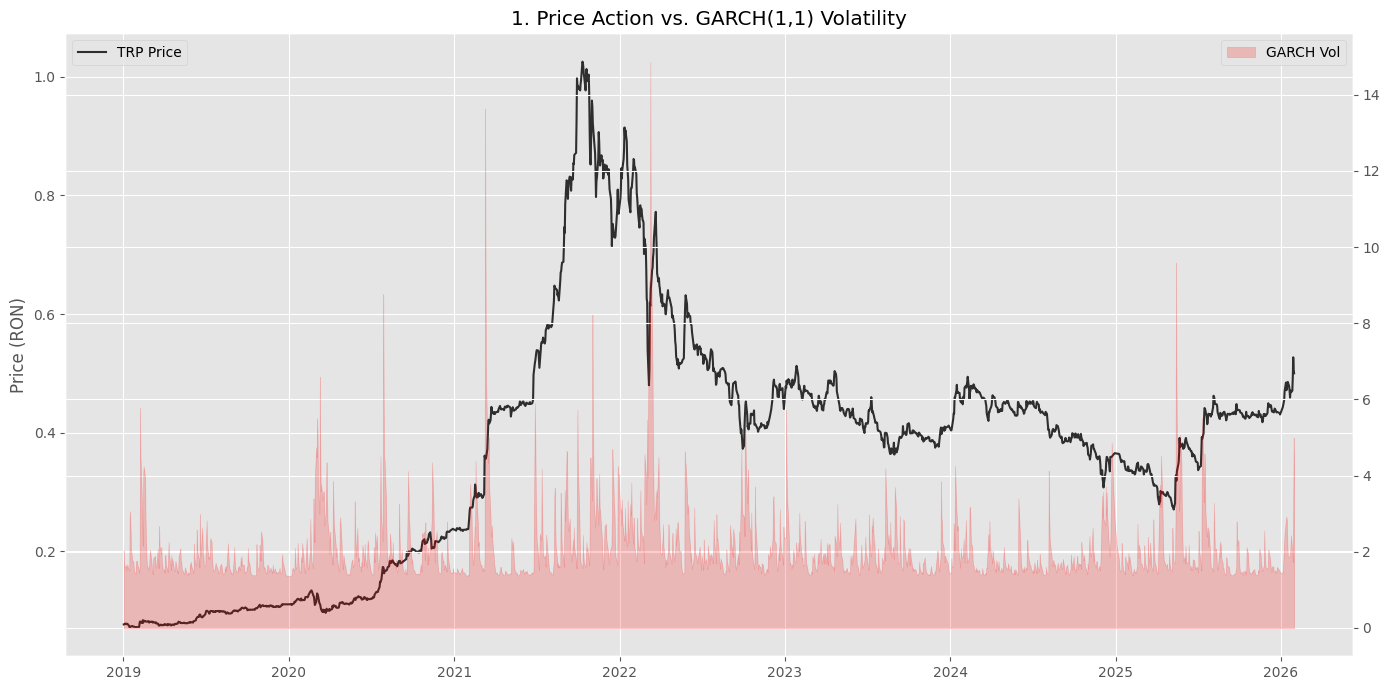

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(trp_close.index, trp_close, color='black', label='TRP Price', alpha=0.8)
plt.ylabel("Price (RON)")
plt.legend(loc='upper left')
plt.twinx()
plt.fill_between(data.index, data['GARCH_Vol'], color='red', alpha=0.2, label='GARCH Vol')
plt.title("1. Price Action vs. GARCH(1,1) Volatility")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Plot 2: Drawdown

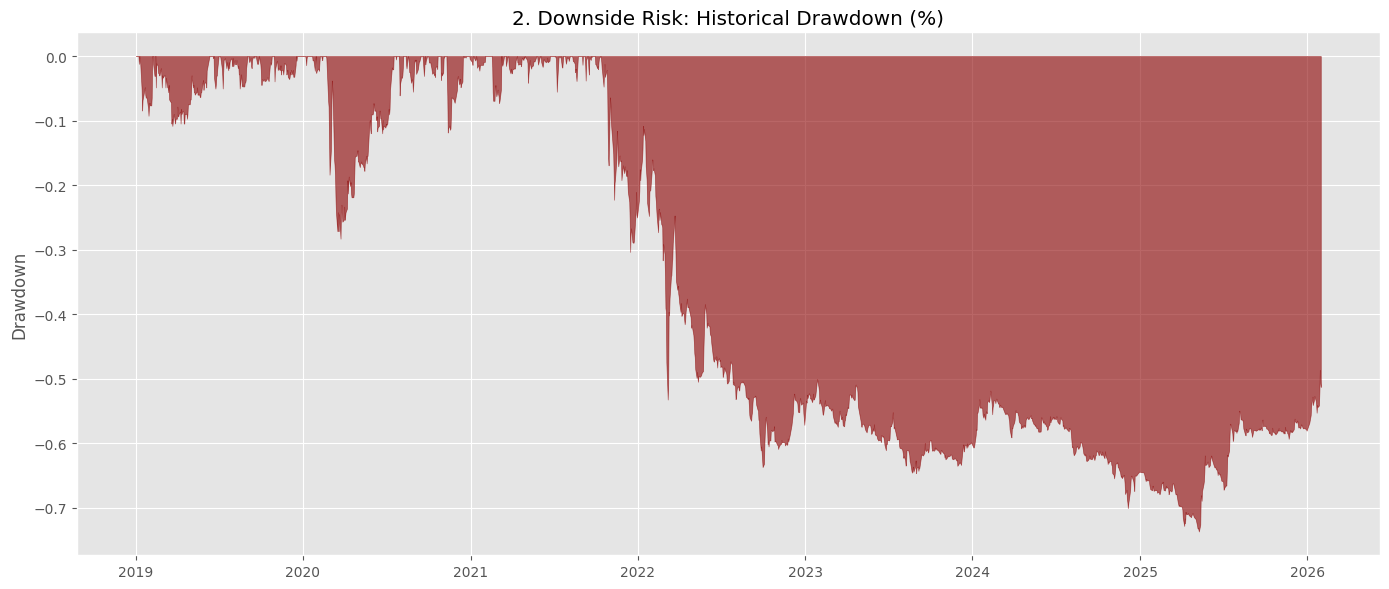

In [15]:
plt.figure(figsize=(14, 6))
plt.fill_between(data.index, data['Drawdown'], color='darkred', alpha=0.6)
plt.title("2. Downside Risk: Historical Drawdown (%)")
plt.ylabel("Drawdown")
plt.tight_layout()
plt.show()

Plot 3: Z-Score

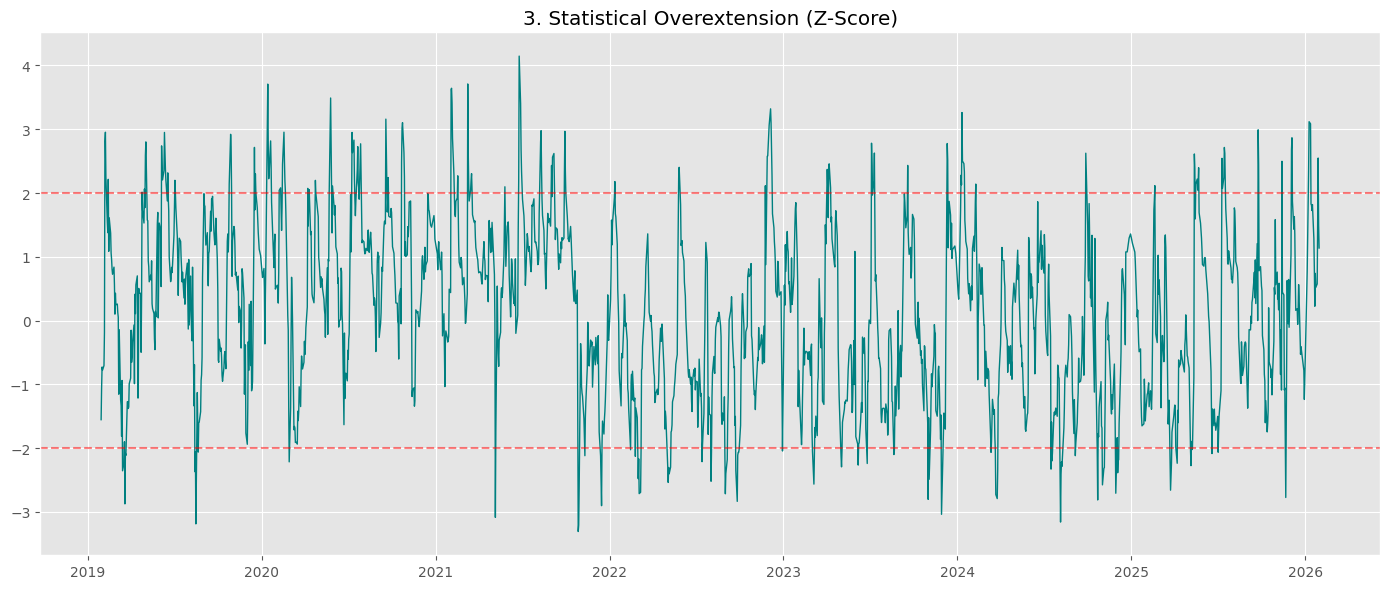

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Z-Score'], color='teal', linewidth=1)
plt.axhline(2, color='red', linestyle='--', alpha=0.5)
plt.axhline(-2, color='red', linestyle='--', alpha=0.5)
plt.title("3. Statistical Overextension (Z-Score)")
plt.tight_layout()
plt.show()

Plot 4: Entropy

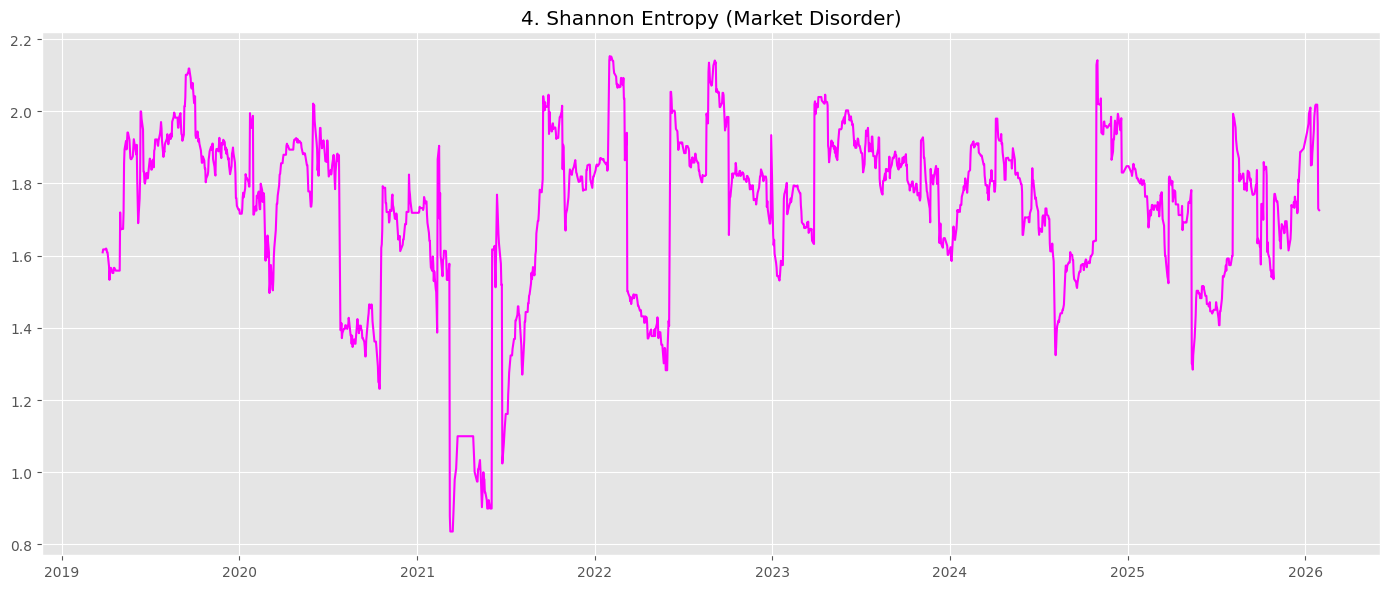

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Entropy'], color='magenta')
plt.title("4. Shannon Entropy (Market Disorder)")
plt.tight_layout()
plt.show()

Plot 5: Efficiency

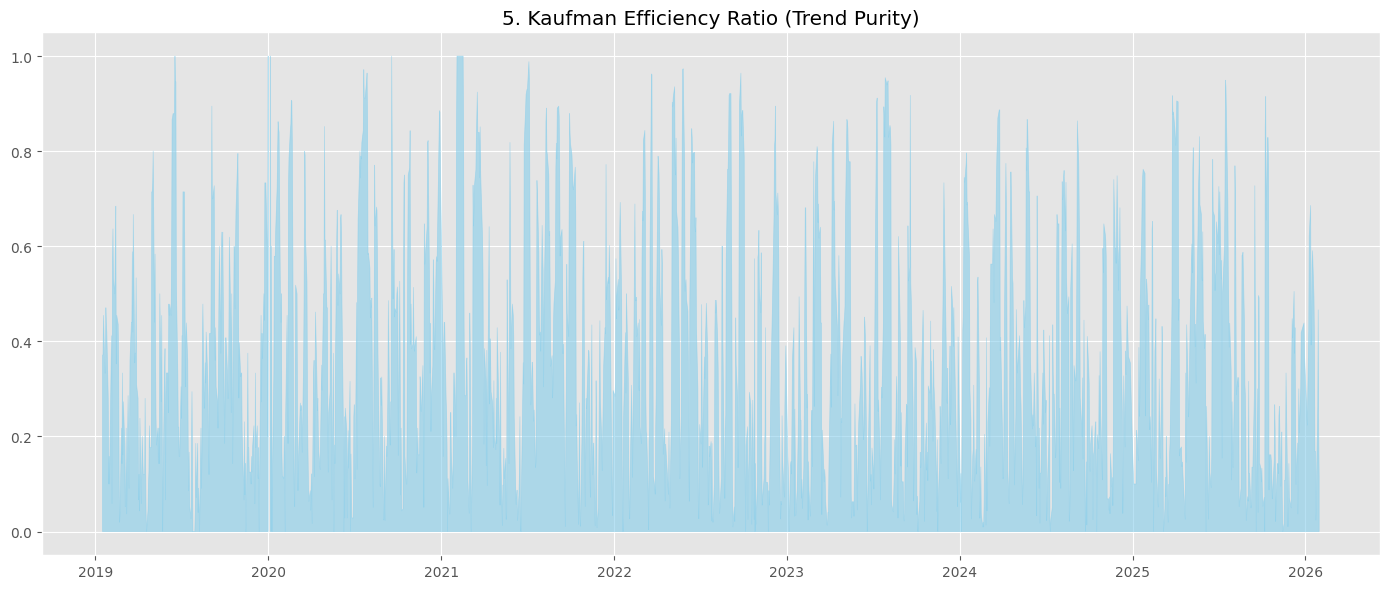

In [18]:
plt.figure(figsize=(14, 6))
plt.fill_between(data.index, data['Efficiency'], color='skyblue', alpha=0.6)
plt.title("5. Kaufman Efficiency Ratio (Trend Purity)")
plt.tight_layout()
plt.show()

Plot 6: QQ Plot (Normality)

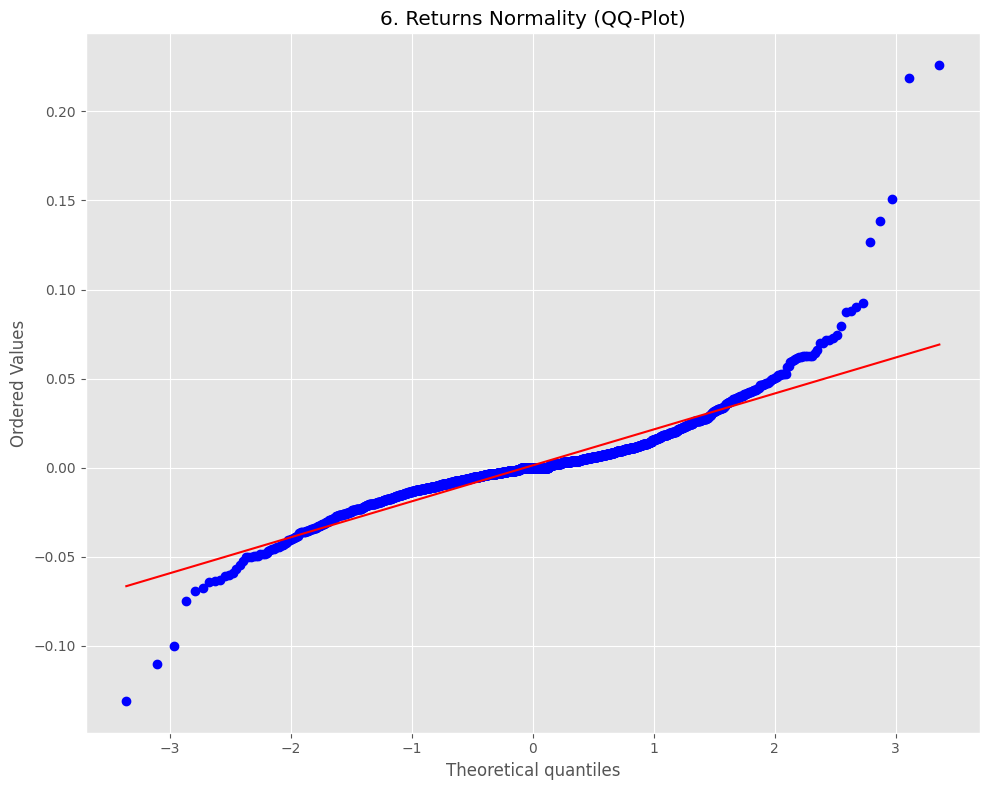

In [19]:
plt.figure(figsize=(10, 8))
stats.probplot(data['Returns'].dropna(), dist="norm", plot=plt)
plt.title("6. Returns Normality (QQ-Plot)")
plt.tight_layout()
plt.show()

Plot 7: Fourier Transform

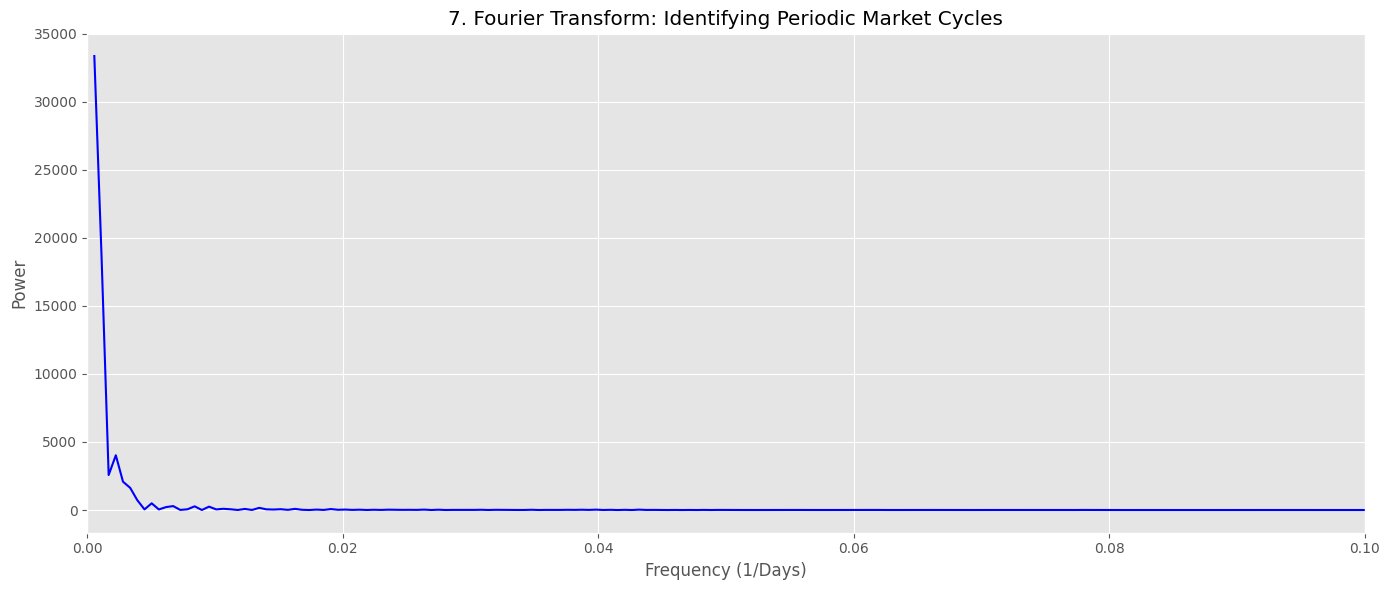

In [20]:
plt.figure(figsize=(14, 6))
fft_vals = np.abs(np.fft.fft(trp_close.values))**2
freqs = np.fft.fftfreq(len(trp_close))
mask = freqs > 0
plt.plot(freqs[mask], fft_vals[mask], color='blue')
plt.xlim(0, 0.1)
plt.title("7. Fourier Transform: Identifying Periodic Market Cycles")
plt.xlabel("Frequency (1/Days)")
plt.ylabel("Power")
plt.tight_layout()
plt.show()

--- 4. TEXT SUMMARY ---

In [21]:
print("\n" + "=" * 40)
print(f"ANALYTICAL SUMMARY FOR {ticker}")
print("=" * 40)
print(f"Current Price:        {trp_close.iloc[-1]:.4f} RON")
print(f"Hurst Exponent:       {hurst_val:.2f} ({'Trending' if hurst_val > 0.5 else 'Mean-Reverting'})")
print(f"Max Drawdown:         {data['Drawdown'].min():.2%}")
print(f"Avg Efficiency:       {data['Efficiency'].mean():.2f}")
print("=" * 40)


ANALYTICAL SUMMARY FOR TRP.RO
Current Price:        0.5000 RON
Hurst Exponent:       0.49 (Mean-Reverting)
Max Drawdown:         -73.65%
Avg Efficiency:       0.37
